In [1]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.models import load_model
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm_notebook as tqdm
import time
from keras_layer_normalization import LayerNormalization
from keras_self_attention import SeqSelfAttention
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("london_merged.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

(17414, 13) (15673, 13) (1765, 13)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

  0%|          | 0/15649 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1741 [00:00<?, ?it/s]

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [3]:
# BI-GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
BI_GRU_ATTENTION_model = load_model('GRU_Single_Attention_model_block.h5', custom_objects=custom_ob)
print('BI-GRU-ATTENTION loaded')

# BI-GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
Minmax_Attention_model = load_model('Minmax_Attention.h5', custom_objects=custom_ob)
print('BI-GRU-ATTENTION loaded')

# BI-GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
Standard_Attention_model = load_model('Standard_Attention.h5', custom_objects=custom_ob)
print('BI-GRU-ATTENTION loaded')

# BI-GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
Power_ATTENTION_model = load_model('GRU_Single_Attention_model_power.h5', custom_objects=custom_ob)
print('BI-GRU-ATTENTION loaded')

BI-GRU-ATTENTION loaded
BI-GRU-ATTENTION loaded
BI-GRU-ATTENTION loaded
BI-GRU-ATTENTION loaded


In [4]:
def predict_model(Model,name,input_num):
    print('-----',name,'-----')
    t1 = time.time()
    
    if input_num == 2:
        y_pred = Model.predict([x_test,x_test])
    y_pred = scaler.inverse_transform(y_pred)#Undo scaling   
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 =  r2_score(y_test, y_pred)
    print('RMSE: ',rmse)
    print('MAE: ',mae)
    print('R-square: ',r2)
    n = len(y_test)
    p = 12
    Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    print('Adj R-square: ',Adj_r2)
    t2 = time.time()
    print('Predict time: ',t2-t1)
    print('----------------')
    return y_pred
    
Bi_G_A = predict_model(BI_GRU_ATTENTION_model,'Bi-G-A',2)
M_A = predict_model(Minmax_Attention_model,'MA',2)
S_A = predict_model(Standard_Attention_model,'SA',2)
P_A = predict_model(Power_ATTENTION_model,'PA',2)

----- Bi-G-A -----
RMSE:  348.3202524400943
MAE:  234.5896298464929
R-square:  0.8594749589420626
Adj R-square:  0.8584990906013825
Predict time:  1.3588097095489502
----------------
----- MA -----
RMSE:  780.7787652518496
MAE:  561.1090054235398
R-square:  0.2939226913805941
Adj R-square:  0.28901937673740374
Predict time:  1.1734962463378906
----------------
----- SA -----
RMSE:  466.244286947542
MAE:  369.69786729982434
R-square:  0.7482187910362169
Adj R-square:  0.7464703104184129
Predict time:  1.1637279987335205
----------------
----- PA -----
RMSE:  640.154285257432
MAE:  464.94284665865297
R-square:  0.5253586374490202
Adj R-square:  0.5220625168757496
Predict time:  1.1654863357543945
----------------


1741


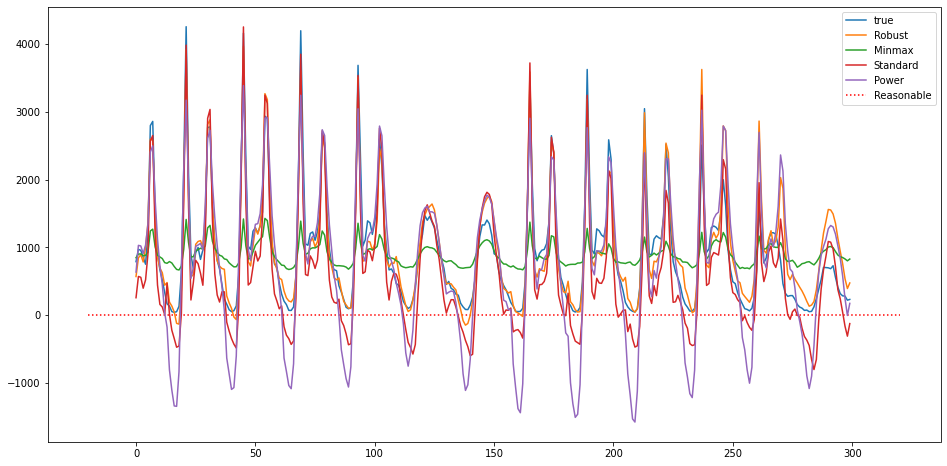

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(Bi_G_A[1200:1500], label='Robust')
plt.plot(M_A[1200:1500], label='Minmax')
plt.plot(S_A[1200:1500], label='Standard')
plt.plot(P_A[1200:1500], label='Power')
plt.hlines(0, -20, 320,color="red",linestyle='dotted',label='Reasonable')
plt.legend()
print(len(y_test))
plt.savefig('NP_predict.png')

1741


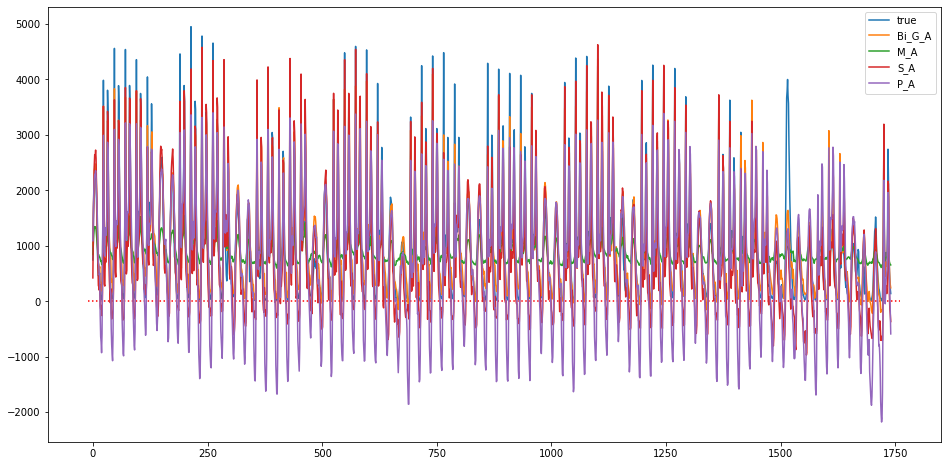

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(Bi_G_A, label='Bi_G_A')
plt.plot(M_A, label='M_A')
plt.plot(S_A, label='S_A')
plt.plot(P_A, label='P_A')
plt.hlines(0, -10, 1760,color="red",linestyle='dotted')
plt.legend()
print(len(y_test))